In [103]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/class_financial-econometrics


In [104]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import numpy as np
from creds import FRED_API
import pandas as pd
import random
from statsmodels.tsa.arima_process import ArmaProcess

In [105]:
plt.style.use("../styler.mplstyle") 

### Question 3

In [106]:
def simulate_with_armaprocess(phi, theta, T, sigma2=1.0, burnin=800, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    ar = np.r_[1, -np.asarray(phi)]
    ma = np.r_[1,  np.asarray(theta)]
    ap = ArmaProcess(ar, ma)
    x = ap.generate_sample(nsample=T, burnin=burnin,
                           scale=np.sqrt(sigma2),
                           distrvs=rng.standard_normal)
    return x, ap


In [107]:
def sample_acovf(x, max_lag=10):
    x = np.asarray(x)
    n = len(x)
    mean = x.mean()
    gammas = []
    for h in range(max_lag+1):
        cov = np.sum((x[:n-h] - mean) * (x[h:] - mean)) / n
        gammas.append(cov)
    return np.array(gammas)


In [108]:
PARAM = [(1,0), (4,0), (0,1), (0,4), (1,1)]
Ts = [100, 1000, 10000]
SIGMA2 = 1.0
MAX_LAG = 10

In [109]:
OUTDIR = "../Figures/Assignment01"
os.makedirs(OUTDIR, exist_ok=True)


In [110]:
for (p,q) in PARAM:
    # random weights
    phi  = np.random.randint(0,1,p)
    theta= np.random.randint(0,1,q)

    for T in Ts:
        # --- simulate via ArmaProcess ---
        x, ap = simulate_with_armaprocess(phi, theta, T, sigma2=SIGMA2, burnin=800)

        g_hat = sample_acovf(x, max_lag=MAX_LAG)
        g_true = ap.acovf(nobs=MAX_LAG+1)

        lags = np.arange(MAX_LAG+1)
        plt.figure(figsize=(7,4.2))
        plt.stem(lags, g_true, label="True ACVF")
        plt.plot(lags, g_hat, label=f"Sample ACVF (T={T})")
        plt.xlabel("Lag")
        plt.ylabel("Autocovariance")
        plt.title(f"ARMA({p},{q}) — Sample vs. True ACVF (T={T})")
        plt.legend()
        plt.tight_layout()


        fname = os.path.join(OUTDIR, f"arma_{p}_{q}_T{T}.png")
        plt.savefig(fname, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Saved {fname}")

/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()


Saved ../Figures/Assignment01/arma_1_0_T100.png
Saved ../Figures/Assignment01/arma_1_0_T1000.png


/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


Saved ../Figures/Assignment01/arma_1_0_T10000.png
Saved ../Figures/Assignment01/arma_4_0_T100.png


/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


Saved ../Figures/Assignment01/arma_4_0_T1000.png
Saved ../Figures/Assignment01/arma_4_0_T10000.png


/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


Saved ../Figures/Assignment01/arma_0_1_T100.png
Saved ../Figures/Assignment01/arma_0_1_T1000.png
Saved ../Figures/Assignment01/arma_0_1_T10000.png


/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


Saved ../Figures/Assignment01/arma_0_4_T100.png
Saved ../Figures/Assignment01/arma_0_4_T1000.png


/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()


Saved ../Figures/Assignment01/arma_0_4_T10000.png
Saved ../Figures/Assignment01/arma_1_1_T100.png


/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")
/tmp/ipykernel_107776/2202879877.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()


Saved ../Figures/Assignment01/arma_1_1_T1000.png
Saved ../Figures/Assignment01/arma_1_1_T10000.png


/tmp/ipykernel_107776/2202879877.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


### Question 4

In [111]:
def get_fred(series_id):
    start_date = '1954-04-01'
    end_date = '2007-12-31'
    url = "https://api.stlouisfed.org/fred/series/observations"

    params = {
        "series_id": series_id,
        "api_key": FRED_API,
        "file_type": "json",
        "frequency": "q",              
        "aggregation_method": "avg", 
        "observation_start": "1954-04-01",
        "observation_end": "2024-12-31"
    }

    response = requests.get(url, params=params)
    data = response.json()["observations"]

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df = df[["date", "value"]].rename(columns={'value': series_id})
    return df

    


gdp   = get_fred("GDPC1") 
pop   = get_fred("CNP16OV")
cpi   = get_fred("CPIAUCSL")
ffr   = get_fred("FEDFUNDS")

df = gdp.merge(pop, on="date", suffixes=("_GDP", "_POP"))
df = df.merge(cpi, on="date")
df = df.merge(ffr, on="date")

df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['date'])

df['GDPC1'] = df['GDPC1'].astype(float)
df['CNP16OV'] = df['CNP16OV'].astype(float)
df['CPIAUCSL'] = df['CPIAUCSL'].astype(float)
df['FEDFUNDS'] = df['FEDFUNDS'].astype(float)


df["RGDP_per_capita"] = df["GDPC1"] / df["CPIAUCSL"]
df["YGR"] = 100 * (np.log(df["RGDP_per_capita"]) - np.log(df['RGDP_per_capita'].shift(-1)))
df['INF'] = 400 * np.log(df['CPIAUCSL']/ df['CPIAUCSL'].shift(-1))


In [112]:
df

,date,GDPC1,CNP16OV,CPIAUCSL,FEDFUNDS,RGDP_per_capita,YGR,INF
0,1954-07-01,2880.482,108443.0,26.840,1.03,107.320492,-2.247781,1.238876
1,1954-10-01,2936.852,108786.0,26.757,0.99,109.760138,-2.682102,-0.537815
2,1955-01-01,3020.746,109130.0,26.793,1.34,112.743851,-1.748896,0.537815
3,1955-04-01,3069.910,109534.0,26.757,1.50,114.732967,-1.267060,-0.298875
4,1955-07-01,3111.379,109884.0,26.777,1.94,116.195952,-0.300551,-1.193274
...,...,...,...,...,...,...,...,...
277,2023-10-01,22960.600,267818.0,308.158,5.33,74.509180,0.505682,-3.638668
278,2024-01-01,23053.545,267712.0,310.974,5.33,74.133352,-0.056208,-2.720218
279,2024-04-01,23223.906,268251.0,313.096,5.33,74.175033,-0.410064,-1.386306
280,2024-07-01,23400.294,268860.0,314.183,5.26,74.479822,0.141854,-2.988335


In [113]:
df['FEDFUNDS'].shift(-1)

0      0.99
1      1.34
2      1.50
3      1.94
4      2.36
       ... 
277    5.33
278    5.33
279    5.26
280    4.65
281     NaN
Name: FEDFUNDS, Length: 282, dtype: float64

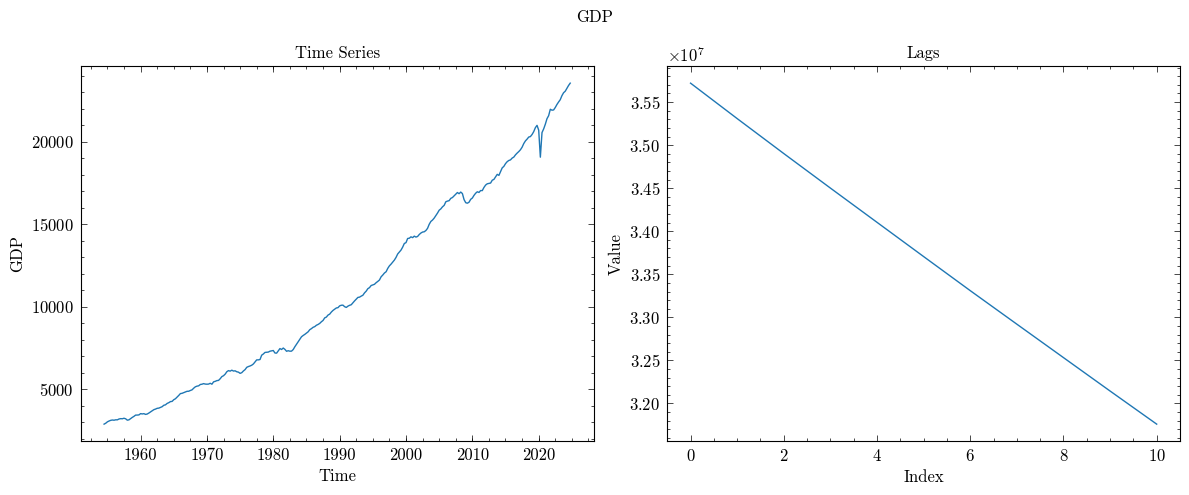

In [114]:
lags = sample_acovf(df['GDPC1'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('GDP')
# First plot: Real GDP Per Capita
axes[0].plot(df['date'], df['GDPC1'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Lags")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'GDP_2.png'))

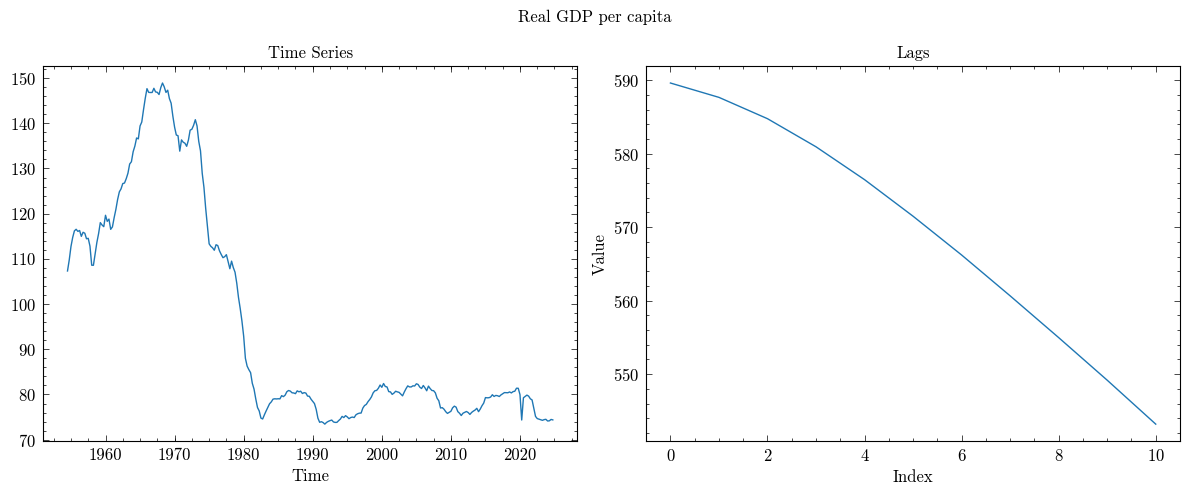

In [115]:
lags = sample_acovf(df['RGDP_per_capita'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Real GDP per capita')
# First plot: Real GDP Per Capita
axes[0].plot(df['date'], df['RGDP_per_capita'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("Real GDP Per Capita")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Lags")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'Real_GDP_2.png'))

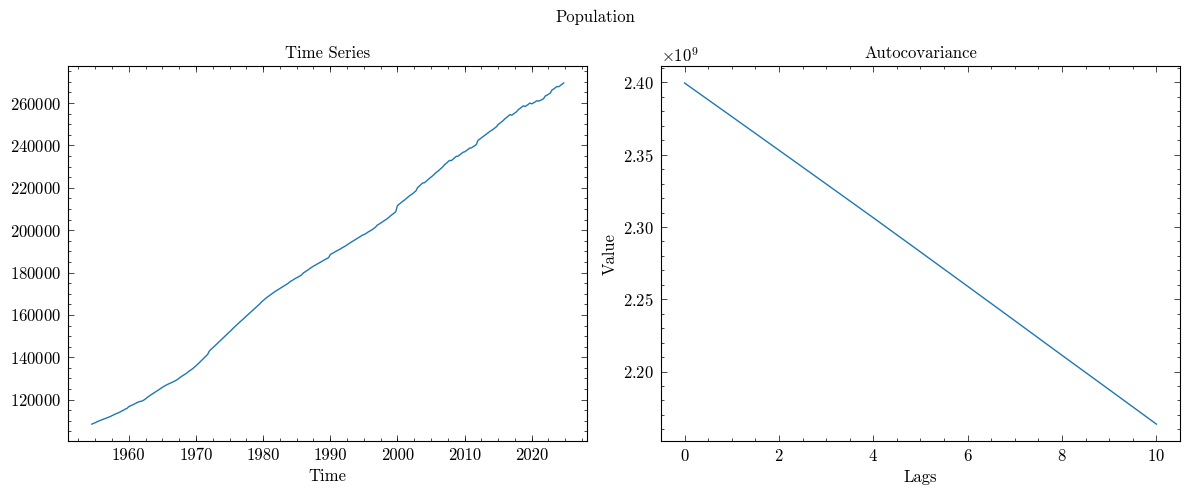

In [116]:
lags = sample_acovf(df['CNP16OV'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Population')
# First plot: Real GDP Per Capita
axes[0].plot(df['date'], df['CNP16OV'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Value")

plt.savefig(os.path.join(OUTDIR, 'Population_2.png'))
plt.tight_layout()

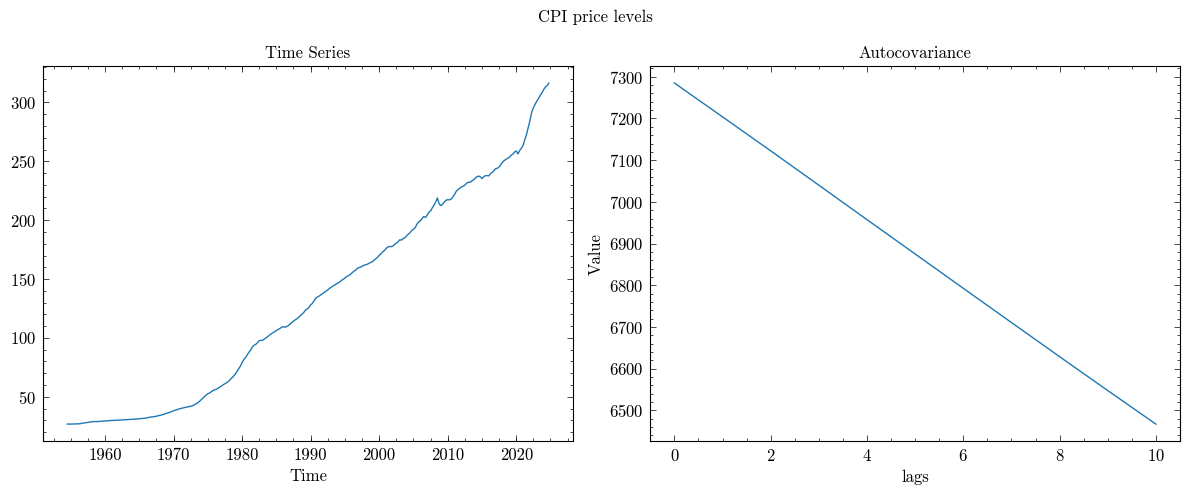

In [117]:
lags = sample_acovf(df['CPIAUCSL'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('CPI price levels')
# First plot: Real GDP Per Capita
axes[0].plot(df['date'], df['CPIAUCSL'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'CPI_2.png'))

In [118]:
df['YGR']

0     -2.247781
1     -2.682102
2     -1.748896
3     -1.267060
4     -0.300551
         ...   
277    0.505682
278   -0.056208
279   -0.410064
280    0.141854
281         NaN
Name: YGR, Length: 282, dtype: float64

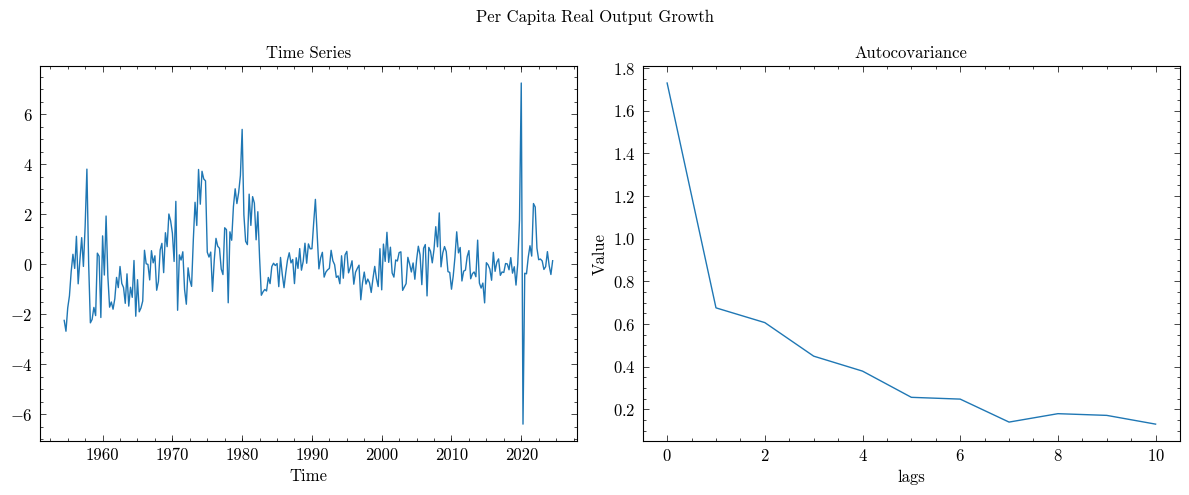

In [119]:
lags = sample_acovf(df['YGR'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Per Capita Real Output Growth')
# First plot: Real GDP Per Capita
axes[0].plot(df['date'], df['YGR'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'YGR_2.png'))

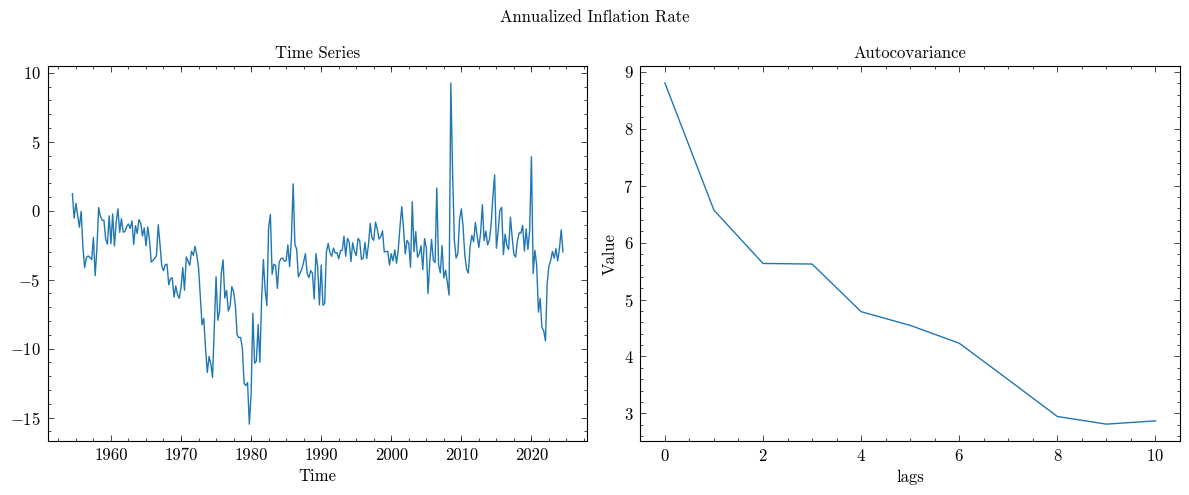

In [120]:
lags = sample_acovf(df['INF'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Annualized Inflation Rate')
# First plot: Real GDP Per Capita
axes[0].plot(df['date'], df['INF'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'INF_2.png'))

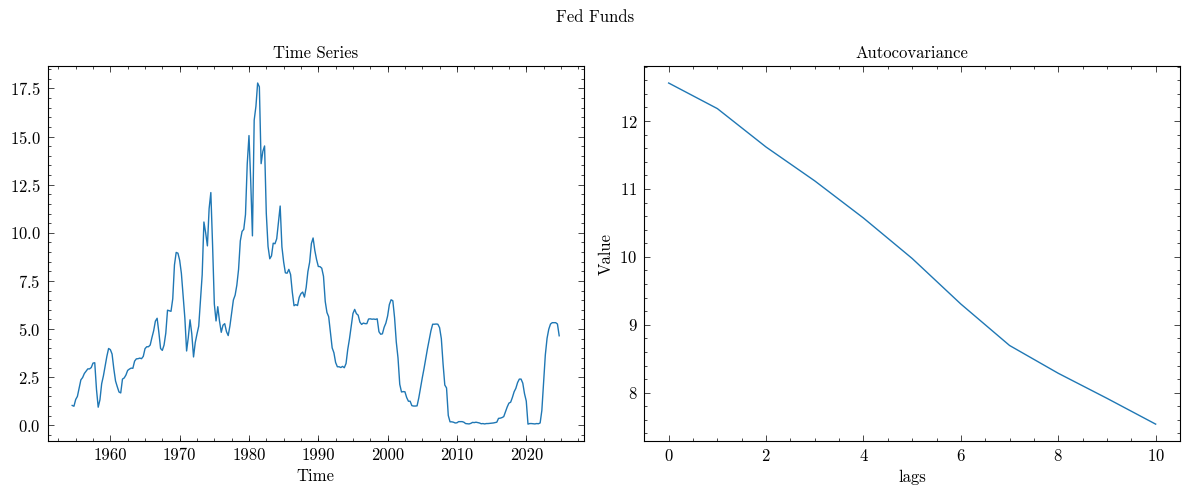

In [121]:
lags = sample_acovf(df['FEDFUNDS'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Fed Funds')
# First plot: Real GDP Per Capita
axes[0].plot(df['date'], df['FEDFUNDS'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'FED_2.png'))
